## Import

In [85]:
import h5py
import os
import numpy as np
from tensorflow.keras.models import load_model

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.metrics import (accuracy_score, f1_score, roc_curve, roc_auc_score, precision_score, 
                             recall_score, confusion_matrix, precision_recall_curve, auc, 
                             average_precision_score)
from imblearn.over_sampling import SMOTE, ADASYN
from sklearn.feature_selection import mutual_info_classif
from scipy.spatial.distance import pdist, squareform
from scipy.stats import ttest_ind
from xgboost import XGBClassifier

from tensorflow.keras.layers import (GlobalAveragePooling2D, BatchNormalization, Input, Conv2D, 
                                     MaxPooling2D, UpSampling2D, Dense, Reshape, Flatten, Dropout)
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestClassifier, VotingClassifier


## caricamento pesi encoder

In [52]:
def encoder(input_shape):
    inputs = Input(shape=input_shape)
    x = Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2), padding='same')(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
    x = GlobalAveragePooling2D()(x)  # Global Average Pooling
    x = Flatten()(x)
    encoded = Dense(32, activation='relu', kernel_regularizer=l1(10e-8))(x)
    encoder_model = Model(inputs, encoded, name='encoder')
    return encoder_model


# Ricrea l'architettura del modello encoder
input_shape = (64, 64, 1)
encoder = encoder(input_shape)

# Carica i pesi salvati
encoder.load_weights('../encoderweightsp_value/encoder32.weights.h5')

## caricamento labels, nomi pazienti e features

In [53]:

file_path = "../CSV/data_rad_clin_DEF.csv"

data = pd.read_csv(file_path)
labels_column = data['label']
labels = labels_column.astype(int).tolist()

labels=np.array(labels)

# Estrazione dei numeri dai nomi dei pazienti
loaded_patients = data['IDs_new'].str.extract(r'(\d+)').astype(int).squeeze().tolist()

print("Labels:", labels)
print("Number of labels:", len(labels))
print("Patient Names: ", loaded_patients )


h5_file_path = '../images_by_patient_final.h5'
loaded_class_images=[]

# Apri il file .h5 e carica le immagini in loaded_class_images
with h5py.File(h5_file_path, 'r') as h5_file:
    # Carica ogni gruppo di immagini come un array numpy
    loaded_class_images = {key: np.array(h5_file[key]) for key in h5_file.keys()}

loaded_class_images= {int(key.split('_')[1]): images for key, images in loaded_class_images.items()}

print("Lunghezza array immagini: ", len(loaded_class_images))
print("Shape immagini primo paziente: ", loaded_class_images[0].shape)
print("Shape immagini secondo paziente: ", loaded_class_images[1].shape)




Labels: [0 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 1 1 0 1 0 0 0 1 1 1 0 1 0
 0 0 1 1 0 0 1 0 1 1 1 1 1 0 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 0 0
 0 1 0 1 0 1 1 0 1 0 1 0 0 0 1 0 0 1 0 0 0 0 0 0 1 1 1 0 0 1 0 0 1 0 0 0 0
 0 1 1 0 0 0 0 0 0 0 0 1 1 0 0 1 0 1]
Number of labels: 129
Patient Names:  [5, 12, 15, 16, 17, 19, 22, 23, 24, 25, 26, 27, 29, 30, 31, 33, 35, 36, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 52, 53, 54, 56, 57, 58, 59, 60, 61, 62, 64, 65, 68, 69, 70, 71, 74, 75, 76, 78, 79, 81, 82, 84, 85, 86, 87, 88, 89, 90, 91, 92, 94, 95, 96, 98, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 123, 124, 126, 127, 128, 129, 133, 135, 136, 137, 138, 139, 141, 142, 144, 146, 147, 149, 150, 153, 155, 158, 159, 161, 163, 166, 168, 169, 170, 171, 175, 176, 178, 182, 183, 188, 189, 190, 193, 197, 199, 200, 205]
Lunghezza array immagini:  129
Shape immagini primo paziente:  (28, 64, 64)
Shape immagini secondo paziente:  (

## ottenimento features da immagini tramite encoder

In [54]:
# Caricamento modello encoder
#encoder = load_model("../encoder_models/encoder_model32.h5", compile=False)

# Funzione per ottenere le feature da una singola immagine
def get_features_from_image(image):
    image = image.astype('float32')
    image = image / 255.0
    # Ottieni le feature dall'encoder
    if len(image.shape) == 2:  # Se l'immagine è 64x64
        image = np.expand_dims(image, axis=-1)  # Aggiungi canale (per immagini in bianco e nero)
    image = np.expand_dims(image, axis=0)  # Aggiungi dimensione batch
    features = encoder.predict(image, verbose=False)
    features = np.squeeze(features)
    return np.array(features)

# Lista per salvare le feature delle immagini
patients = []

# Ottieni le feature per ogni immagine nella lista
for i in range(len(loaded_class_images)):
    features_list = []
    for img in loaded_class_images[i]:
        features = get_features_from_image(img)
        features_list.append(features)
    fetures_list = np.array(features_list)
    patients.append(features_list)

## funzioni feature selection 

In [55]:
## funzione per creare array da array di array
def continue_array(filtered_patients, labels):
    all_features = []
    for patient in filtered_patients:
        for image_features in patient:
            all_features.append(image_features)

    all_features_array = np.array(all_features)
    expanded_labels = []
    expanded_patient_ids = []

    for i in range(len(filtered_patients)):
        num_images = len(filtered_patients[i])
        expanded_labels.extend([labels[i]] * num_images)
        expanded_patient_ids.extend([loaded_patients[i]] * num_images)

    expanded_labels_array = np.array(expanded_labels)
    expanded_patient_ids_array = np.array(expanded_patient_ids)

    return all_features_array, expanded_labels_array, expanded_patient_ids_array


## funzioni per feature correlation
def filter_highly_correlated_features(df, corr, threshold=0.85):
    columns = np.full((corr.shape[0],), True, dtype=bool)
    removed_features = []

    for i in range(corr.shape[0]):
        for j in range(i + 1, corr.shape[0]):
            if corr.iloc[i, j] >= threshold:
                if columns[j]:
                    columns[j] = False
                    removed_features.append(df.columns[j])

    return removed_features


def perform_correlation(z_train, y_train, numero = 32, threshold = 0.85):
    all_images, _, _= continue_array(z_train, y_train)

    df = pd.DataFrame(all_images, columns=[f'feature_{i}' for i in range(numero)])

    corr_matrix = df.corr()

    features_selected = filter_highly_correlated_features(df, corr_matrix, threshold)
    
    return features_selected

## funzione per rimuovere le features con p_value maggiore della treshold
def select_features_by_p_value(x_train_expanded, y_train_expanded, p_value_threshold=0.05):

    p_values = []
    num_features = x_train_expanded.shape[1]

    for i in range(num_features):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)

    p_values = np.array(p_values)

    selected_features_indices = np.where(p_values < p_value_threshold)[0]

    sorted_indices = selected_features_indices[np.argsort(p_values[selected_features_indices])]

    x_train_expanded = x_train_expanded[:, sorted_indices]

    return x_train_expanded, sorted_indices



## funzione per rimozione di features specifiche
def remove_features_from_patients(patients, features_to_remove):
    feature_indices_to_remove = [int(feature.split('_')[1]) for feature in features_to_remove]
    
    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.delete(image_features, feature_indices_to_remove, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))    

    return final_patients


## FEATURE SELECTION LASSO
def select_features_with_lasso(X, y, alpha=0.001):
    
    lasso = Lasso(alpha=alpha)
    lasso.fit(X, y)
    coefficients = lasso.coef_
    selected_features = np.where(coefficients != 0)[0]
    X_selected = X[:, selected_features]

    return X_selected, selected_features

## FEATURE SELECTION LOGISTIC
def logistic_regression_feature_selection(X, y, num_features):
    lr = LogisticRegression(max_iter=1000, random_state=42)
    lr.fit(X, y)
    coef_abs = np.abs(lr.coef_)
    feature_importances = np.mean(coef_abs, axis=0)
    selected_features = feature_importances.argsort()[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features

## FEATURE SELECTION MRMR
def mrmr_feature_selection(X, y, num_features):
    mi = mutual_info_classif(X, y)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    distances = squareform(pdist(X_scaled.T, 'euclidean'))
    
    selected_features = []
    selected_indices = []

    first_feature_index = np.argmax(mi)
    selected_features.append(first_feature_index)
    selected_indices.append(first_feature_index)
    
    for _ in range(num_features - 1):
        max_relevance = -np.inf
        selected_feature_index = -1
        
        for i in range(X.shape[1]):
            if i in selected_indices:
                continue
            
            relevance = mi[i]
            redundancy = np.mean(distances[i, selected_indices])
            
            mrmr_score = relevance - redundancy
            
            if mrmr_score > max_relevance:
                max_relevance = mrmr_score
                selected_feature_index = i
        
        selected_features.append(selected_feature_index)
        selected_indices.append(selected_feature_index)

    X_selected = X[:, selected_indices]
    return X_selected, selected_indices

## FEATURE SELECTION RANDOM FOREST
def rf_feature_selection(X, y, num_features):
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X, y)
    feature_importances = rf.feature_importances_
    selected_features = np.argsort(feature_importances)[-num_features:][::-1]
    X_selected = X[:, selected_features]
    return X_selected, selected_features


## FEATURE SELECTION P_VALUE
# Seleziona e ordina le feature basate sui p-value con un test t di Student poi 
# ordina le feature in base al p-value in ordine crescente e seleziona le prime `num_features` caratteristiche.

def p_value_feature_selection(x_train_expanded, y_train_expanded, num_features):
    p_values = []
    num_features_total = x_train_expanded.shape[1]

    # Calcolo dei p-value per ciascuna feature
    for i in range(num_features_total):
        feature = x_train_expanded[:, i]
        group_0 = feature[y_train_expanded == 0]
        group_1 = feature[y_train_expanded == 1]
        t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
        p_values.append(p_val)


    p_values = np.array(p_values)

    # Ordinare tutte le caratteristiche in base ai p-value (dal più piccolo al più grande)
    sorted_indices = np.argsort(p_values)
    sorted_indices = sorted_indices[:num_features]

    x_train_selected = x_train_expanded[:, sorted_indices]

    return x_train_selected, sorted_indices



## funzione per lasciare solo le features indicate per array di array
def keep_features_in_patients(patients, features_to_keep):

    feature_indices_to_keep = [int(feature) for feature in features_to_keep]

    final_patients = []
    for patient in patients:
        new_patients = []
        for image_features in patient:
            new_patient = np.take(image_features, feature_indices_to_keep, axis=0)
            new_patients.append(new_patient)
        final_patients.append(np.array(new_patients))

    return final_patients


## funzione per lasciare solo le features indicate per array
def filter_patients_features(filtered_patients, selected_features):

    filtered_patients_selected = []

    for patient_features in filtered_patients:
        # Select only the features specified in selected_features
        patient_features_selected = patient_features[:, selected_features]
        filtered_patients_selected.append(patient_features_selected)

    return filtered_patients_selected




## funzioni  classificazione

In [77]:

## funzione per effettuarr majority voting o mean su tutte le slice di un paziente, per passare da una predizione sulla slice
## alla predizione per il paziente
def prob_to_binary(predictions_proba, patient_scores, threshold, mode):
        final_predictionarray=[]          
        if(mode=='MV'): ## majority voting
            for p in predictions_proba:
                test_patient_predictions=[]
                for proba in p:               
                    predictions_binary = 1 if proba[0][1] > threshold else 0
                    test_patient_predictions.append(predictions_binary)
                count_0 = np.sum(np.array(test_patient_predictions)==0) 
                count_1 = np.sum(np.array(test_patient_predictions)==1)                                   
                final_prediction = 0 if count_0 > count_1 else 1
                final_predictionarray.append(final_prediction)
        
        elif (mode=='Mean'): ## mean
            for score in patient_scores:
                predictions_binary = 1 if score > threshold else 0
                final_predictionarray.append(predictions_binary)    
    
        return final_predictionarray


def classification_method(selector, alpha, classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, num_features, modePrediction, thresholds=np.arange(0.001, 0.501, 0.001), mode = "Val", selected_features= [0]):

    if(mode == "Val"):
            selected_features = None 
            
            if num_features != len(x_train_expanded[0]) or alpha != 0:
                if selector == "lasso":
                    X_selected, selected_features = select_features_with_lasso(x_train_expanded, y_train_expanded, alpha)
                elif selector == "logistic": 
                    X_selected, selected_features = logistic_regression_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "mrmr":
                    X_selected, selected_features = mrmr_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector == "rf":
                    X_selected, selected_features = rf_feature_selection(x_train_expanded, y_train_expanded, num_features)
                elif selector=="p_value":
                    X_selected, selected_features= p_value_feature_selection(x_train_expanded,y_train_expanded, num_features)
                else:
                    print("Wrong selector. Choose between: mrmr, rf, logistic, p_value, lasso")
                    return
                
                features_test = filter_patients_features(features_test, selected_features)
            else:
                X_selected = x_train_expanded
                selected_features = list(range(len(x_train_expanded[0])))  # Selezioniamo tutte le feature se non si fa feature selection
            number_features = len(selected_features) 
        
            smote = SMOTE(random_state=42)
            #adasyn = ADASYN(random_state=42)

            X_resampled, y_resampled = smote.fit_resample(X_selected, y_train_expanded)
            classifier.fit(X_resampled, y_resampled)
   
    if (mode == "Test"): ## non si effettua nuovamente il training e la feature selection
        features_test = filter_patients_features(features_test, selected_features)
        number_features = len(selected_features)

  
    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità
        
    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
    
    # Valuta le performance utilizzando diverse threshold
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    ## se non viene specificato usi il parametro di default 
    ## viene calcolata la threshold che porta a un f1 migliore e effettuata la prediction con quella
    if(len(thresholds)!=1):
        for threshold in thresholds:
            binary_predictions = prob_to_binary(temp_array, patient_scores, threshold, modePrediction)
            f1 = f1_score(y_test, binary_predictions)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold
                best_precision = precision_score(y_test, binary_predictions)
                best_recall = recall_score(y_test, binary_predictions)
                best_prediction=binary_predictions

    else: ## qui vuol dire che è il set di test che usa la threshold migliore che viene passata dal validation
        best_threshold = thresholds
        best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, modePrediction)
        best_f1_score = f1_score(y_test, best_prediction)
        best_precision = precision_score(y_test, best_prediction)
        best_recall = recall_score(y_test, best_prediction)

    #print(f"La migliore threshold è {best_threshold} con f1score di {best_f1_score} e precision {best_precision} e recall {best_recall}.")
    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)

    precision, recall, _ = precision_recall_curve(y_test, patient_scores) ## utili per ricostruire grafici
    pr_auc = average_precision_score(y_test, patient_scores)

    #fpr, tpr, _ = roc_curve(y_test, best_prediction)
    roc_auc= roc_auc_score(y_test, patient_scores)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, best_threshold, number_features, selected_features, classifier



In [80]:

## questa funzione è da utilizzare quando si fa il training sul test e gli vengono già passate le features, quindi non viene effettuata feature selection
## ma solo allenamento del classificatore

def classification_method_test_intero(classifier, x_train_expanded, y_train_expanded, patients_test, y_test, features_test, thresholds, mode):
       
    smote = SMOTE(random_state=42)
    #adasyn = ADASYN(random_state=42)


    X_resampled, y_resampled = smote.fit_resample(x_train_expanded, y_train_expanded)
    #X_resampled, y_resampled = adasyn.fit_resample(x_train_expanded, y_train_expanded)
    classifier.fit(X_resampled, y_resampled)


    temp_array = []
    patient_scores = []
    
    for x in range(len(patients_test)):
        patient_predictions = []
        patient_predictions1 = []
        r=len(features_test[x])
        for i in range(r):
            dato = features_test[x][i].reshape(1, -1)
            prediction = classifier.predict_proba(dato)
            prediction1 = classifier.predict_proba(dato)[:,1]
            patient_predictions.append(prediction)
            patient_predictions1.append(prediction1)
            mean=np.mean(patient_predictions1)

        patient_scores.append(mean) ## contiene la media delle probabilità
        temp_array.append(patient_predictions) ## contiene tutte le probabilità


    best_f1_score = 0
    best_threshold = None
    best_precision=0
    best_recall=0
    best_prediction=[]
 
    if isinstance(thresholds, (int, float, complex)):
        thresholds=[thresholds]

    best_threshold = thresholds
    best_prediction=prob_to_binary(temp_array, patient_scores, best_threshold, mode)
    best_f1_score = f1_score(y_test, best_prediction)
    best_precision = precision_score(y_test, best_prediction)
    best_recall = recall_score(y_test, best_prediction)

    y_test= np.array(y_test)
    best_prediction=np.array(best_prediction)
    test_accuracy = accuracy_score(y_test, best_prediction)


    conf= confusion_matrix(y_test, best_prediction)
    return best_f1_score, best_precision, best_recall, conf, test_accuracy



## Split dati

In [58]:

# patients_train contiene il nome dei pazienti (5,12 etc)
# y_train contiene le labels
# features_train contiene array di array dove ogni paziente ha varie immagini rappresentate da n features

patients_train, patients_test, y_train, y_test, features_train, features_test= train_test_split(loaded_patients, labels, patients, test_size=0.3, shuffle=False, random_state=1)

print("Number of train patients: ", len(features_train))
print("Number of test patients: ", len(features_test))

print("Number of features for every image: ", len(features_train[0][0]) )



Number of train patients:  63
Number of test patients:  39
Number of val patients:  27
Number of features for every image:  32


## parametri

In [59]:
alpha_values = np.linspace(0, 0.006, 30).tolist()

selectors=['p_value', 'mrmr','rf', 'logistic', 'lasso']
classifiers=['RandomForest', 'Logistic', 'XgBoost', 'MLP', 'SVM', 'ensemble']

## Features con p-value

## LOOP che prova tutti i classificatori, selector e tutti i numeri di features da 2 al max
Uno effettua il majority voting e l'altro il mean per trovare le predizioni, poi si valutano le performance migliori.
Viene effettuato il fine tuning della threshold. La classificazione sul set di test viene effettuata con la threshold migliore per la val 

In [60]:

n_folds=5
skf = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

template_dict = {
                'fold': None,
                'classifier': None,
                'selector': None,
                'mode': None,
                'alpha': None,
                'num_features': None,
                'pr_auc': None,
                'best_precision': None,
                'best_recall': None,
                'roc_auc': None,
                'f1': None,
                'accuracy': None,
                'confusion_matrix': [],
                'best_threshold': None,
                'selected_features': []
            }

## creazione di dizionari vuoti (range con numero elevato casuale)
results_val = [template_dict.copy() for _ in range(9000000)]
results_val.append(template_dict.copy())

k=0
for fold_idx, (train_index, val_index) in enumerate(skf.split(features_train, y_train)):
    print("Starting with fold:", fold_idx)

    ## creazione fold
    features_train = []
    features_val = []
        
        
    for idx in train_index:
            features=[]
            for x in range(len(features_train[idx])):
                features.append(features_train[idx][x])
            features=np.array(features)
            features_train.append(features)
            
    j=0
    for idx in val_index:
            features=[]
            for x in range(len(features_train[idx])):
                features.append(features_train[idx][x])
            features=np.array(features)
            features_val.append(features)

    y_train, y_val = y_train[train_index], y_train[val_index]
    patients_train, patients_val = patients_train[train_index], patients_train[val_index]

    ## fine creazione fold
    starting_features = len(features_train[0][0])
    i=0

    features=perform_correlation(features_train, y_train, starting_features, 0.85)

    final_patients_train=remove_features_from_patients(features_train, features)
    final_patients_test=remove_features_from_patients(features_test, features)
    final_patients_val=remove_features_from_patients(features_val, features)

    x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)
    x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded)
            
    final_patients_test=keep_features_in_patients(final_patients_test, sf)
    final_patients_val=keep_features_in_patients(final_patients_val, sf)
    print(f"Scelte {len(sf)} features\n")

    
    for classifier in classifiers:
        print("Starting with classifier:", classifier)
        for selector in selectors: 
            print("Doing with selector:", selector)
            results_test_MV[i][selector] = {
                    'classifier': classifier,
                    'alpha': [],
                    'num_features': [],
                    'pr_auc': [],
                    'best_precision' :[],
                    'best_recall':[],
                    'roc_auc':[],
                    'f1':[],
                    'accuracy':[],
                    'confusion_matrix':[],
                    'best_threshold':[],
                    'selected_features': []
                    }
            results_val_MV[i][selector] = {
                    'classifier': classifier,
                    'alpha': [],
                    'num_features': [],
                    'pr_auc': [],
                    'best_precision' :[],
                    'best_recall':[],
                    'roc_auc':[],
                    'f1':[],
                    'accuracy':[],
                    'confusion_matrix':[],
                    'best_threshold':[],
                    'selected_features': []
                    }

            if selector == 'lasso':
                    for alpha in alpha_values:
                            print("sto facendo alpha:",alpha)

                            if(classifier=='RandomForest'):
                                classi = RandomForestClassifier(n_estimators=100, random_state=42)
                            if(classifier=='Logistic'):
                                classi = LogisticRegression()
                            if(classifier=='SVM'):
                                classi = SVC(kernel='rbf', probability=True, random_state=42)
                            if(classifier=='XgBoost'):
                                classi = XGBClassifier()
                            if(classifier=='MLP'):
                                classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                            
                            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, classifier= classification_method(
                                selector, alpha, classi, x_train_expanded, y_train_expanded, 
                                patients_val, y_val, final_patients_val, 0, 'MV'
                            )

                            if(best_f1_score==0 and best_precision==0 and best_recall==0):
                                break
                        
                            results_val_MV[i][selector]['alpha'].append(alpha)
                            results_val_MV[i][selector]['selected_features'].append(selected_features)
                            results_val_MV[i][selector]['num_features'].append(number_features)
                            results_val_MV[i][selector]['pr_auc'].append(pr_auc)
                            results_val_MV[i][selector]['best_precision'].append(best_precision)
                            results_val_MV[i][selector]['best_recall'].append(best_recall)
                            results_val_MV[i][selector]['roc_auc'].append(roc_auc)
                            results_val_MV[i][selector]['f1'].append(best_f1_score)
                            results_val_MV[i][selector]['accuracy'].append(test_accuracy)
                            results_val_MV[i][selector]['confusion_matrix'].append(conf)
                            results_val_MV[i][selector]['best_threshold'].append(bt)

                            ## classifico il test

                            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                        selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, 0, 'MV',  bt, "Test", selected_features)
                            
                            
                            results_test_MV[i][selector]['alpha'].append(alpha)
                            results_test_MV[i][selector]['num_features'].append(number_features)
                            results_test_MV[i][selector]['selected_features'].append(selected_features)
                            results_test_MV[i][selector]['pr_auc'].append(pr_auc)
                            results_test_MV[i][selector]['best_precision'].append(best_precision)
                            results_test_MV[i][selector]['best_recall'].append(best_recall)
                            results_test_MV[i][selector]['roc_auc'].append(roc_auc)
                            results_test_MV[i][selector]['f1'].append(best_f1_score)
                            results_test_MV[i][selector]['accuracy'].append(test_accuracy)
                            results_test_MV[i][selector]['confusion_matrix'].append(conf)
                            results_test_MV[i][selector]['best_threshold'].append(bt)
                            
                            

            else:
                        for t in range(2, len(x_train_expanded[0])+1):
                            
                            print("sto facendo features:",t)
                            
                            if(classifier=='RandomForest'):
                                classi = RandomForestClassifier(n_estimators=100, random_state=42)
                            if(classifier=='Logistic'):
                                classi = LogisticRegression()
                            if(classifier=='SVM'):
                                classi = SVC(kernel='rbf', probability=True, random_state=42)
                            if(classifier=='XgBoost'):
                                classi = XGBClassifier()
                            if(classifier=='MLP'):
                                classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                            
                            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, classifier= classification_method(
                                selector, 0, classi, x_train_expanded, y_train_expanded, 
                                patients_val, y_val, final_patients_val, t, 'MV'
                            )
                            results_val_MV[i][selector]['num_features'].append(t)
                            results_val_MV[i][selector]['pr_auc'].append(pr_auc)
                            results_val_MV[i][selector]['selected_features'].append(selected_features)
                            results_val_MV[i][selector]['best_precision'].append(best_precision)
                            results_val_MV[i][selector]['best_recall'].append(best_recall)
                            results_val_MV[i][selector]['roc_auc'].append(roc_auc)
                            results_val_MV[i][selector]['f1'].append(best_f1_score)
                            results_val_MV[i][selector]['accuracy'].append(test_accuracy)
                            results_val_MV[i][selector]['confusion_matrix'].append(conf)
                            results_val_MV[i][selector]['best_threshold'].append(bt)

                            ## classifico test
                            best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                            selector, 0, classifier, x_train_expanded, y_train_expanded, 
                                            patients_test, y_test, final_patients_test, t, 'MV', bt, "Test", selected_features)
                            
                            results_test_MV[i][selector]['num_features'].append(t)
                            results_test_MV[i][selector]['selected_features'].append(selected_features)
                            results_test_MV[i][selector]['pr_auc'].append(pr_auc)
                            results_test_MV[i][selector]['best_precision'].append(best_precision)
                            results_test_MV[i][selector]['best_recall'].append(best_recall)
                            results_test_MV[i][selector]['roc_auc'].append(roc_auc)
                            results_test_MV[i][selector]['f1'].append(best_f1_score)
                            results_test_MV[i][selector]['accuracy'].append(test_accuracy)
                            results_test_MV[i][selector]['confusion_matrix'].append(conf)
                            results_test_MV[i][selector]['best_threshold'].append(bt)

        
            
        i=i+1


            

Starting with classifier: RandomForest
Doing with selector: p_value
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
Doing with selector: mrmr
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
Doing with selector: rf
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

In [61]:

results_test_Mean=[{} for _ in range(len(classifiers))]
results_val_Mean = [{} for _ in range(len(classifiers))]
starting_features = len(features_train[0][0])
i=0

features=perform_correlation(features_train, y_train, starting_features, 0.85)

final_patients_train=remove_features_from_patients(features_train, features)
final_patients_test=remove_features_from_patients(features_test, features)
final_patients_val=remove_features_from_patients(features_val, features)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train)
x_train_expanded, sf= select_features_by_p_value(x_train_expanded, y_train_expanded)
        
final_patients_test=keep_features_in_patients(final_patients_test, sf)
final_patients_val=keep_features_in_patients(final_patients_val, sf)
print(f"Scelte {len(sf)} features\n")

for classifier in classifiers:
    print("Starting with classifier:", classifier)
    for selector in selectors: 
        print("Doing with selector:", selector)
        results_test_Mean[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }
        results_val_Mean[i][selector] = {
                'classifier': classifier,
                'alpha': [],
                'num_features': [],
                'pr_auc': [],
                'best_precision' :[],
                'best_recall':[],
                'roc_auc':[],
                'f1':[],
                'accuracy':[],
                'confusion_matrix':[],
                'best_threshold':[],
                'selected_features': []
                }

        if selector == 'lasso':
                for alpha in alpha_values:
                        print("sto facendo alpha:",alpha)

                        if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                        if(classifier=='Logistic'):
                             classi = LogisticRegression()
                        if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                        if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                        if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                        
                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, classifier= classification_method(
                            selector, alpha, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, 0, 'Mean'
                        )

                        if(best_f1_score==0 and best_precision==0 and best_recall==0):
                            break
                    
                        results_val_Mean[i][selector]['alpha'].append(alpha)
                        results_val_Mean[i][selector]['selected_features'].append(selected_features)
                        results_val_Mean[i][selector]['num_features'].append(number_features)
                        results_val_Mean[i][selector]['pr_auc'].append(pr_auc)
                        results_val_Mean[i][selector]['best_precision'].append(best_precision)
                        results_val_Mean[i][selector]['best_recall'].append(best_recall)
                        results_val_Mean[i][selector]['roc_auc'].append(roc_auc)
                        results_val_Mean[i][selector]['f1'].append(best_f1_score)
                        results_val_Mean[i][selector]['accuracy'].append(test_accuracy)
                        results_val_Mean[i][selector]['confusion_matrix'].append(conf)
                        results_val_Mean[i][selector]['best_threshold'].append(bt)

                        ## classifico il test

                        best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                    selector, alpha, classifier, x_train_expanded, y_train_expanded, 
                                    patients_test, y_test, final_patients_test, 0, 'Mean',  bt, "Test", selected_features)
                        
                        
                        results_test_Mean[i][selector]['alpha'].append(alpha)
                        results_test_Mean[i][selector]['num_features'].append(number_features)
                        results_test_Mean[i][selector]['selected_features'].append(selected_features)
                        results_test_Mean[i][selector]['pr_auc'].append(pr_auc)
                        results_test_Mean[i][selector]['best_precision'].append(best_precision)
                        results_test_Mean[i][selector]['best_recall'].append(best_recall)
                        results_test_Mean[i][selector]['roc_auc'].append(roc_auc)
                        results_test_Mean[i][selector]['f1'].append(best_f1_score)
                        results_test_Mean[i][selector]['accuracy'].append(test_accuracy)
                        results_test_Mean[i][selector]['confusion_matrix'].append(conf)
                        results_test_Mean[i][selector]['best_threshold'].append(bt)
                        
                        

        else:
                    for t in range(2, len(x_train_expanded[0])+1):
                         
                         print("sto facendo features:",t)
                         
                         if(classifier=='RandomForest'):
                             classi = RandomForestClassifier(n_estimators=100, random_state=42)
                         if(classifier=='Logistic'):
                             classi = LogisticRegression()
                         if(classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
                         if(classifier=='XgBoost'):
                             classi = XGBClassifier()
                         if(classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')
                         
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, _, selected_features, classifier= classification_method(
                            selector, 0, classi, x_train_expanded, y_train_expanded, 
                            patients_val, y_val, final_patients_val, t, 'Mean'
                        )
                         results_val_Mean[i][selector]['num_features'].append(t)
                         results_val_Mean[i][selector]['pr_auc'].append(pr_auc)
                         results_val_Mean[i][selector]['selected_features'].append(selected_features)
                         results_val_Mean[i][selector]['best_precision'].append(best_precision)
                         results_val_Mean[i][selector]['best_recall'].append(best_recall)
                         results_val_Mean[i][selector]['roc_auc'].append(roc_auc)
                         results_val_Mean[i][selector]['f1'].append(best_f1_score)
                         results_val_Mean[i][selector]['accuracy'].append(test_accuracy)
                         results_val_Mean[i][selector]['confusion_matrix'].append(conf)
                         results_val_Mean[i][selector]['best_threshold'].append(bt)

                         ## classifico test
                         best_f1_score, best_precision, best_recall, conf, test_accuracy, precision, recall, pr_auc, roc_auc, bt, number_features, selected_features, _= classification_method(
                                        selector, 0, classifier, x_train_expanded, y_train_expanded, 
                                        patients_test, y_test, final_patients_test, t, 'Mean', bt, "Test", selected_features)
                         
                         results_test_Mean[i][selector]['num_features'].append(t)
                         results_test_Mean[i][selector]['selected_features'].append(selected_features)
                         results_test_Mean[i][selector]['pr_auc'].append(pr_auc)
                         results_test_Mean[i][selector]['best_precision'].append(best_precision)
                         results_test_Mean[i][selector]['best_recall'].append(best_recall)
                         results_test_Mean[i][selector]['roc_auc'].append(roc_auc)
                         results_test_Mean[i][selector]['f1'].append(best_f1_score)
                         results_test_Mean[i][selector]['accuracy'].append(test_accuracy)
                         results_test_Mean[i][selector]['confusion_matrix'].append(conf)
                         results_test_Mean[i][selector]['best_threshold'].append(bt)


    
        
    i=i+1


            

Starting with classifier: RandomForest
Doing with selector: p_value
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
Doing with selector: mrmr
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo features: 5
sto facendo features: 6
sto facendo features: 7
sto facendo features: 8
sto facendo features: 9
sto facendo features: 10
sto facendo features: 11
sto facendo features: 12
sto facendo features: 13
sto facendo features: 14
sto facendo features: 15
sto facendo features: 16
Doing with selector: rf
Scelte 16 features

sto facendo features: 2
sto facendo features: 3
sto facendo features: 4
sto facendo feat

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:1473: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.214e+02, tolerance: 4.732e-02 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using

sto facendo alpha: 0.00020689655172413793
sto facendo alpha: 0.00041379310344827585
sto facendo alpha: 0.0006206896551724137
sto facendo alpha: 0.0008275862068965517
sto facendo alpha: 0.0010344827586206897
sto facendo alpha: 0.0012413793103448274
sto facendo alpha: 0.0014482758620689654
sto facendo alpha: 0.0016551724137931034
sto facendo alpha: 0.0018620689655172414
sto facendo alpha: 0.0020689655172413794
sto facendo alpha: 0.0022758620689655173
sto facendo alpha: 0.002482758620689655
sto facendo alpha: 0.002689655172413793
sto facendo alpha: 0.002896551724137931
sto facendo alpha: 0.003103448275862069
sto facendo alpha: 0.003310344827586207
sto facendo alpha: 0.003517241379310345
sto facendo alpha: 0.0037241379310344828
sto facendo alpha: 0.00393103448275862
sto facendo alpha: 0.004137931034482759
sto facendo alpha: 0.004344827586206896
sto facendo alpha: 0.004551724137931035
sto facendo alpha: 0.004758620689655172
sto facendo alpha: 0.00496551724137931
sto facendo alpha: 0.0051724

## Salvataggio dizionari

In [217]:
import pickle

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_val128_noShuffle.pkl"
file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_val64.pkl"

# Salvare i risultati in file pickle
with open(file_path, 'wb') as file:
    pickle.dump(results_test_Mean, file)

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_test128_noShuffle.pkl"
file_path ="/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_test64.pkl"

with open(file_path, 'wb') as file:
    pickle.dump(results_val_Mean, file)

print("File Pickle creati con successo.")

File Pickle creati con successo.


In [218]:
import pickle

file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_val64.pkl"
#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_val64.pkl"
#file_path =
with open(file_path, 'rb') as file:
    results_val = pickle.load(file)

#file_path = "C:\\Users\\bsbar\\Desktop\\Tesi\\ThesisPlaques\\risultatidiz\\results_test128_noShuffle.pkl"
file_path = "/Users/alessiamenozzi/Desktop/risultatidiznuovi/results_test64.pkl"
with open(file_path, 'rb') as file:
    results_test = pickle.load(file)

print("File Pickle caricati con successo.")

File Pickle caricati con successo.


## PLOTs

### ROC per ogni classificatore
(qui solo array per MV)

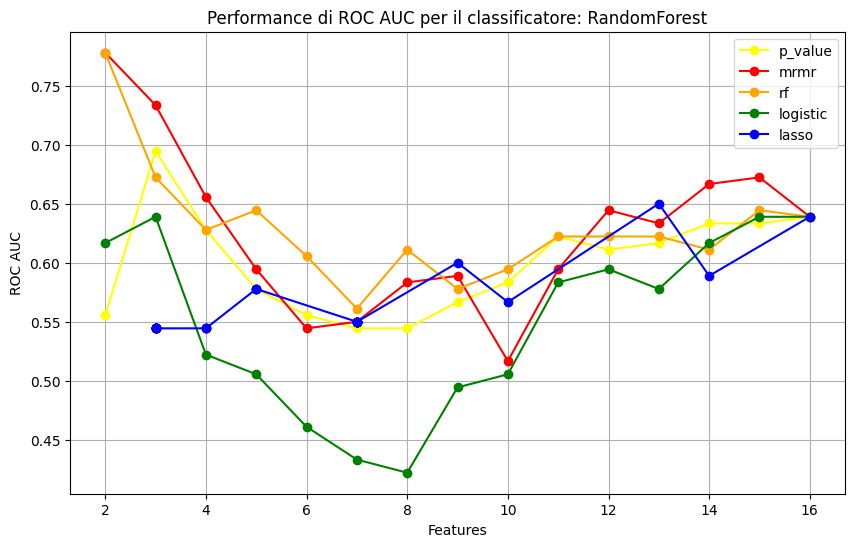

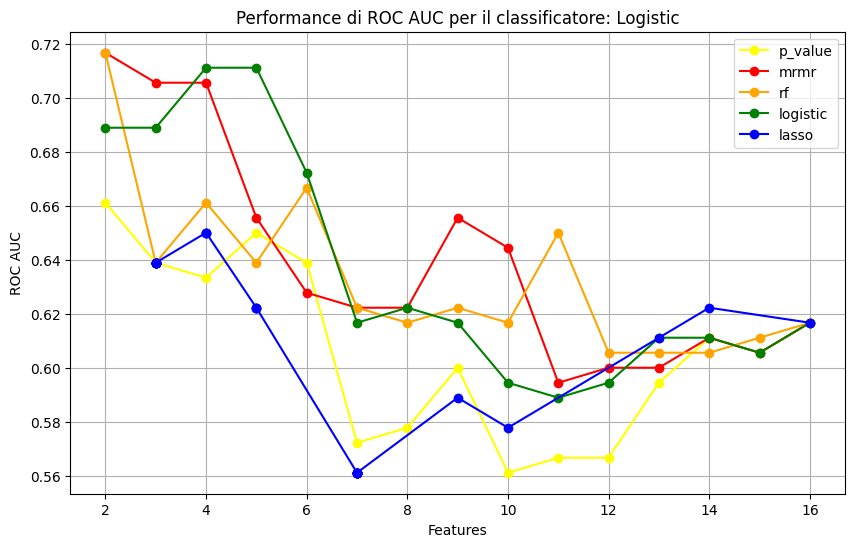

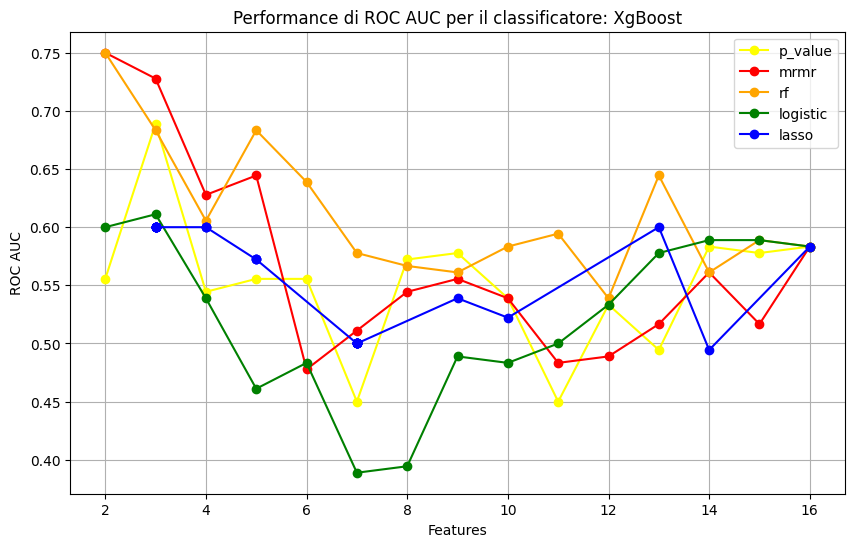

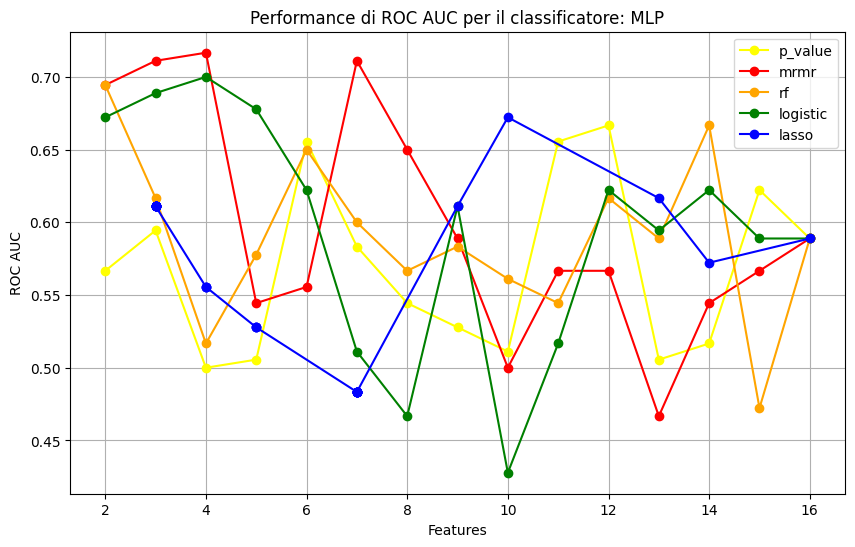

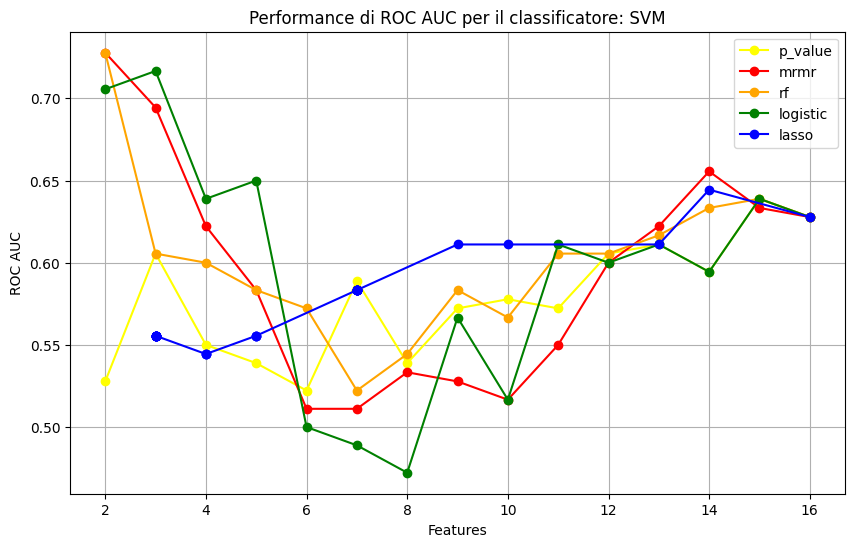

In [82]:

colors = {
    'lasso': 'blue',
    'logistic': 'green', 
    'mrmr': 'red', 
    'rf': 'orange',
    'p_value': 'yellow'

}

for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        num_features = results_val_MV[i][selector]['num_features']
        roc_auc = results_val_MV[i][selector]['roc_auc'] 

        plt.plot(num_features, roc_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di ROC AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('ROC AUC')
    plt.legend()
    plt.grid(True)
    plt.show()


### PR curve per ogni classificatore
(qui solo array per MV)

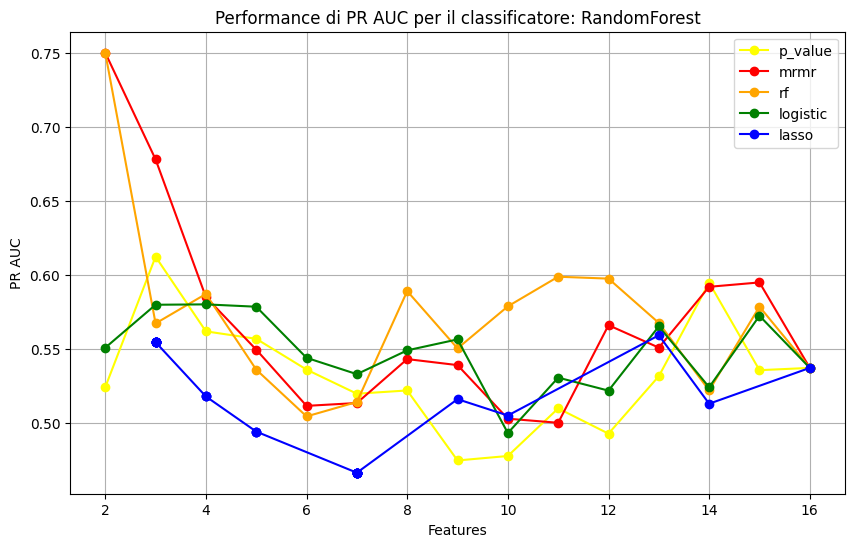

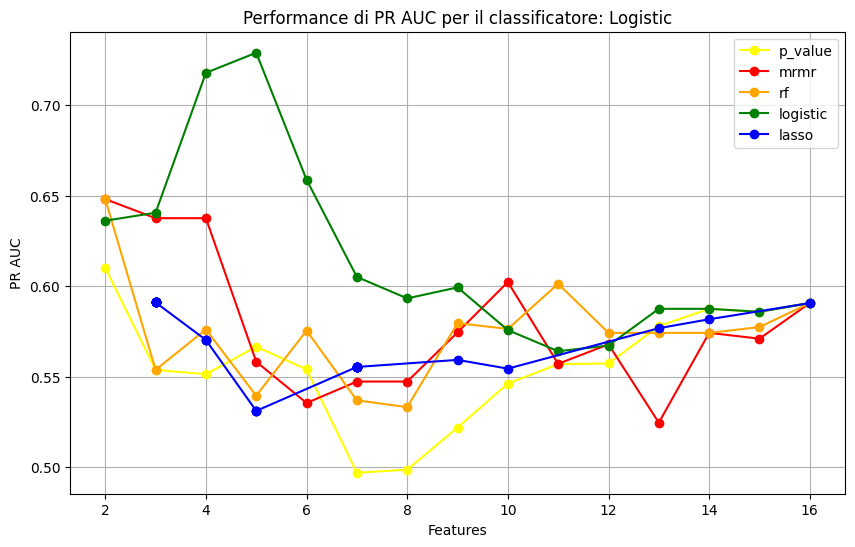

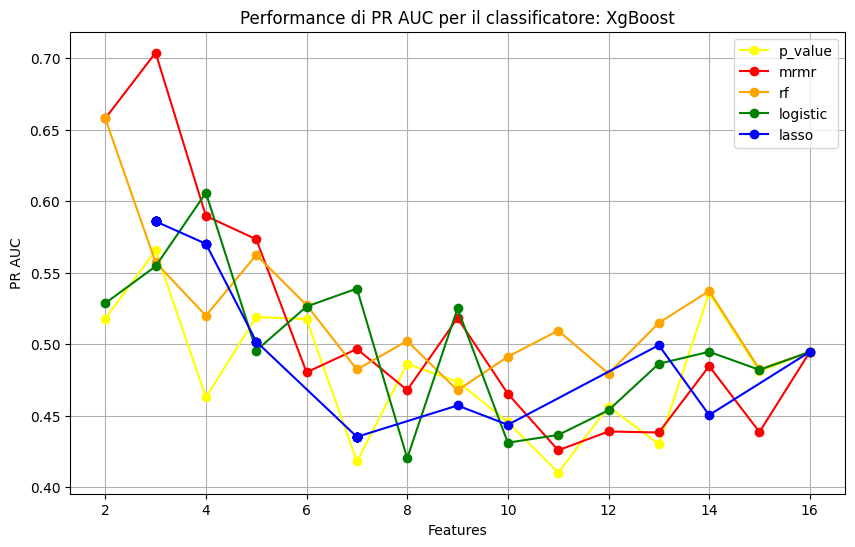

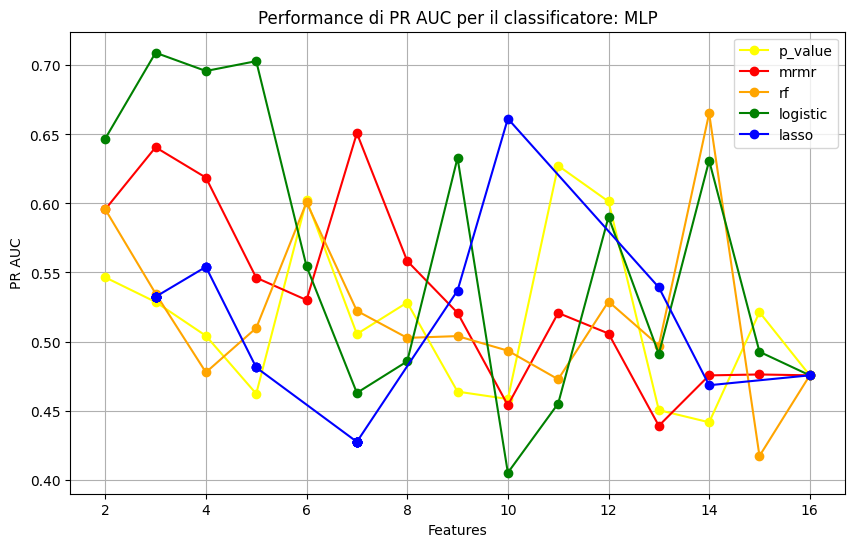

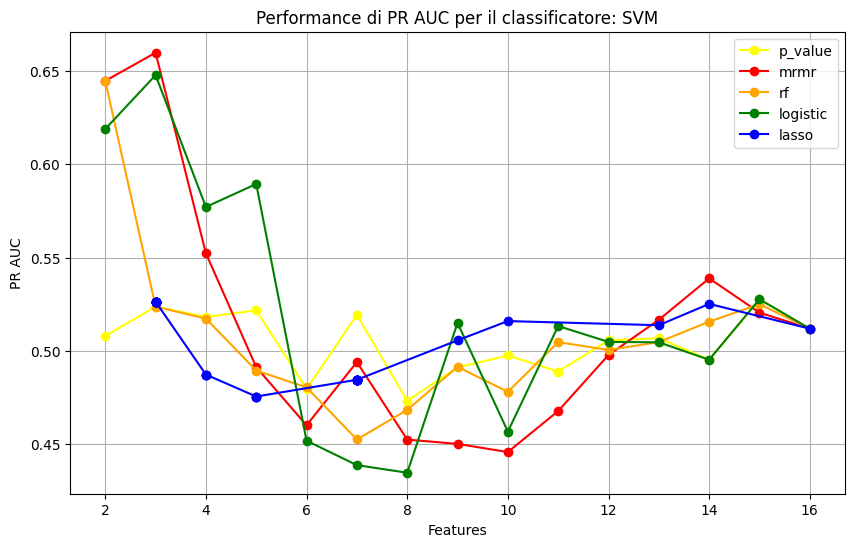

In [84]:
colors = {
    'lasso': 'blue',
    'logistic': 'green', 
    'mrmr': 'red', 
    'rf': 'orange',
    'p_value': 'yellow'

}
for i, classifier in enumerate(classifiers):
    plt.figure(figsize=(10, 6))
    for selector in selectors:
        num_features = results_val_MV[i][selector]['num_features']
        pr_auc = results_val_MV[i][selector]['pr_auc']

        plt.plot(num_features, pr_auc, marker='o', label=selector, color=colors.get(selector, 'black'))

    plt.title(f'Performance di PR AUC per il classificatore: {classifier}')
    plt.xlabel('Features')
    plt.ylabel('PR AUC')
    plt.legend()
    plt.grid(True)
    plt.show()

## Trovando il miglior risultato per il validation

In [65]:
# Dizionario per memorizzare i migliori risultati per ogni classificatore
best_results_per_classifier = {
    classifier: {
        'selector': None,
        'result': None,
        'mode': None
    } for classifier in classifiers
}

# Funzione per confrontare i risultati e determinare se è migliore
def is_better(result, best_result):
    if 'result' not in best_result or best_result['result'] is None:
        return True
    
    if result['f1'] > best_result['result']['f1']:
        return True
    elif result['f1'] == best_result['result']['f1']:
        if result['pr_auc'] > best_result['result']['pr_auc']:
            return True
        elif result['pr_auc'] == best_result['result']['pr_auc']:
            if result['roc_auc'] > best_result['result']['roc_auc']:
                return True
    return False

# Funzione per trovare i migliori risultati per un dato set di risultati
def find_best_results(results_val, mode):
    for i, classifier in enumerate(classifiers):
        for selector in selectors:
            num_results = len(results_val[i][selector]['f1'])

            for j in range(num_results):
                current_result = {
                    'classifier': classifier,
                    'selector': selector,
                    'f1': results_val[i][selector]['f1'][j],
                    'pr_auc': results_val[i][selector]['pr_auc'][j],
                    'roc_auc': results_val[i][selector]['roc_auc'][j],
                    'accuracy': results_val[i][selector]['accuracy'][j],
                    'num_features': results_val[i][selector]['num_features'][j],
                    'confusion_matrix': results_val[i][selector]['confusion_matrix'][j],
                    'best_precision': results_val[i][selector]['best_precision'][j],
                    'best_recall': results_val[i][selector]['best_recall'][j],
                    'best_threshold': results_val[i][selector]['best_threshold'][j],
                    'selected_features': results_val[i][selector]['selected_features'][j]
                }

                if is_better(current_result, best_results_per_classifier[classifier]):
                    best_results_per_classifier[classifier] = {
                        'selector': selector,
                        'result': current_result,
                        'mode': mode
                    }

# Trova i migliori risultati per entrambi i set di risultati
find_best_results(results_val_Mean, 'mean')
find_best_results(results_val_MV, 'majority voting')

classifier_alphas = {}

# Stampa i migliori risultati per ogni classificatore
for classifier, best_result_info in best_results_per_classifier.items():
    best_result = best_result_info['result']
    best_selector = best_result_info['selector']
    mode = best_result_info['mode']
    
    print(f"Miglior risultato per il classificatore {classifier}: ")
    print(f"Selector {best_selector} and mode {mode}:")
    print(f"F1 score: {best_result['f1']}")
    print(f"PR AUC: {best_result['pr_auc']}")
    print(f"ROC AUC: {best_result['roc_auc']}")
    print(f"Accuracy: {best_result['accuracy']}")
    print(f"Numero di features: {best_result['num_features']}")
    print(f"Confusion Matrix:")
    print(best_result['confusion_matrix'])
    #print(f"Best Precision: {best_result['best_precision']}")
    #print(f"Best Recall: {best_result['best_recall']}")
    #print(f"Best Threshold: {best_result['best_threshold']}")
    #print(f"Selected Features: {best_result['selected_features']}")

    # Se il selettore è "lasso", recupera e stampa anche il valore di alpha
    if best_selector == 'lasso':
        if mode == 'mean':
            idx = results_val_Mean[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
            alpha_opt = results_val_Mean[classifiers.index(classifier)][best_selector]['alpha'][idx]
        else:
            idx = results_val_MV[classifiers.index(classifier)][best_selector]['f1'].index(best_result['f1'])
            alpha_opt = results_val_MV[classifiers.index(classifier)][best_selector]['alpha'][idx]
        print(f"Alpha: {alpha_opt}")
    else:
        alpha_opt = 0

    classifier_alphas[classifier] = alpha_opt
    
    print("--------------------")

print("--------------------")

# Trova il miglior classificatore globale
best_overall_result = None
best_overall_classifier = None
best_overall_selector = None
best_overall_mode = None

for classifier, best_result_info in best_results_per_classifier.items():
    if 'result' in best_result_info and best_result_info['result'] is not None:
        best_result = best_result_info['result']
        selector = best_result_info['selector']
        mode = best_result_info['mode']
        
        # Se non abbiamo ancora un miglior risultato globale, lo impostiamo direttamente
        if best_overall_result is None:
            best_overall_result = best_result
            best_overall_classifier = classifier
            best_overall_selector = selector
            best_overall_mode = mode
        else:
            # Confrontiamo i risultati per trovare il miglior classificatore globale
            if (best_result['f1'] > best_overall_result['f1'] or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] > best_overall_result['pr_auc']) or
                (best_result['f1'] == best_overall_result['f1'] and
                 best_result['pr_auc'] == best_overall_result['pr_auc'] and
       
                 best_result['roc_auc'] > best_overall_result['roc_auc'])):
                
                best_overall_result = best_result
                best_overall_classifier = classifier
                best_overall_selector = selector
                best_overall_mode = mode

# Stampa il miglior risultato globale
if best_overall_result is not None:
    best_threshold_fin = best_overall_result['best_threshold']
    selected_features_fin = best_overall_result['selected_features']
    alpha_fin = classifier_alphas[best_overall_classifier]

    print(f"Miglior classificatore globale: {best_overall_classifier} (selector {best_overall_selector}, mode {best_overall_mode})")
    print(f"Selected Features: {best_overall_result['selected_features']}")
    if best_overall_selector== 'lasso':
         print(f"Alpha: {classifier_alphas[best_overall_classifier]}")

    print(f"F1 score: {best_overall_result['f1']}")
    print(f"PR AUC: {best_overall_result['pr_auc']}")
    print(f"ROC AUC: {best_overall_result['roc_auc']}")
    print(f"Accuracy: {best_overall_result['accuracy']}")
    print(f"Numero di features: {best_overall_result['num_features']}")
    print(f"Confusion Matrix:")
    print(best_overall_result['confusion_matrix'])
    print(f"Best Precision: {best_result['best_precision']}")
    print(f"Best Recall: {best_result['best_recall']}")
    print(f"Best Threshold: {best_result['best_threshold']}")
    print(f"Selected Features: {best_result['selected_features']}")
    

else:
    print("Nessun miglior risultato globale trovato.")


Miglior risultato per il classificatore RandomForest: 
Selector mrmr and mode mean:
F1 score: 0.7741935483870968
PR AUC: 0.7498534474927665
ROC AUC: 0.7777777777777778
Accuracy: 0.7407407407407407
Numero di features: 2
Confusion Matrix:
[[ 8  7]
 [ 0 12]]
--------------------
Miglior risultato per il classificatore Logistic: 
Selector mrmr and mode majority voting:
F1 score: 0.7333333333333333
PR AUC: 0.6481216639111377
ROC AUC: 0.7166666666666667
Accuracy: 0.7037037037037037
Numero di features: 2
Confusion Matrix:
[[ 8  7]
 [ 1 11]]
--------------------
Miglior risultato per il classificatore XgBoost: 
Selector rf and mode mean:
F1 score: 0.7586206896551724
PR AUC: 0.5149339358898182
ROC AUC: 0.6444444444444444
Accuracy: 0.7407407407407407
Numero di features: 13
Confusion Matrix:
[[ 9  6]
 [ 1 11]]
--------------------
Miglior risultato per il classificatore MLP: 
Selector mrmr and mode majority voting:
F1 score: 0.75
PR AUC: 0.6187087089467119
ROC AUC: 0.7166666666666666
Accuracy: 0.

## Risultati sul test della configurazione migliore tra num_features, classificatore e selector senza allenare di nuovo

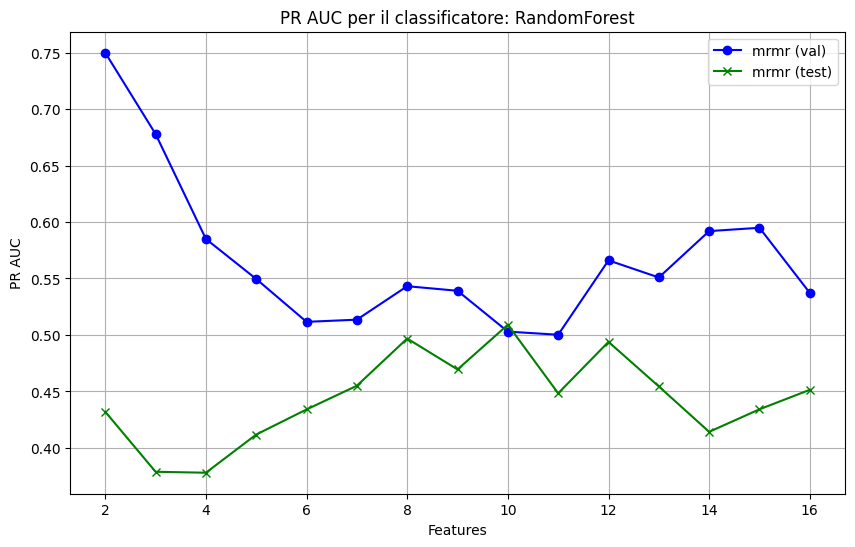

Risultati per 2 features:
PR AUC: 0.43201246208212146
ROC AUC: 0.462962962962963
F1: 0.4117647058823529
Precision: 0.3181818181818182
Recall: 0.5833333333333334
Accuracy: 0.48717948717948717
Confusion Matrix:
[[12 15]
 [ 5  7]]



In [66]:

classifier = best_overall_classifier
selector = best_overall_selector
mode = best_overall_mode

# Seleziona il set di risultati di test corretto in base alla modalità
if mode == 'mean':
    results_test = results_test_Mean
else:
    results_test = results_test_MV

# Recupera i dati di PR AUC e numero di features per results_val e results_test
num_features_val = results_val_Mean[classifiers.index(classifier)][selector]['num_features'] if mode == 'mean' else results_val_MV[classifiers.index(classifier)][selector]['num_features']
pr_auc_val = results_val_Mean[classifiers.index(classifier)][selector]['pr_auc'] if mode == 'mean' else results_val_MV[classifiers.index(classifier)][selector]['pr_auc']

num_features_test = results_test[classifiers.index(classifier)][selector]['num_features']
pr_auc_test = results_test[classifiers.index(classifier)][selector]['pr_auc']


color_val = 'blue'
color_test = 'green'

plt.figure(figsize=(10, 6))

plt.plot(num_features_val, pr_auc_val, marker='o', label=f'{selector} (val)', color=color_val)
plt.plot(num_features_test, pr_auc_test, marker='x', label=f'{selector} (test)', color=color_test)

plt.title(f'PR AUC per il classificatore: {classifier}')
plt.xlabel('Features')
plt.ylabel('PR AUC')
plt.legend()
plt.grid(True)
plt.show()

specific_num_features = len(selected_features_fin)

if specific_num_features in num_features_test:
    index = num_features_test.index(specific_num_features)
    
    print(f"Risultati per {specific_num_features} features:")
    print(f"PR AUC: {results_test[classifiers.index(classifier)][selector]['pr_auc'][index]}")
    print(f"ROC AUC: {results_test[classifiers.index(classifier)][selector]['roc_auc'][index]}")
    print(f"F1: {results_test[classifiers.index(classifier)][selector]['f1'][index]}")
    print(f"Precision: {results_test[classifiers.index(classifier)][selector]['best_precision'][index]}")
    print(f"Recall: {results_test[classifiers.index(classifier)][selector]['best_recall'][index]}")
    print(f"Accuracy: {results_test[classifiers.index(classifier)][selector]['accuracy'][index]}")
    print(f"Confusion Matrix:\n{results_test[classifiers.index(classifier)][selector]['confusion_matrix'][index]}\n")
else:
    print(f"Numero di features {specific_num_features} non trovato nei risultati di test.")


## Risultati sul test della configurazione migliore tra num_features, classificatore e selector allenando di nuovo il classificatore (includendo il validation set nel training)

In [81]:
if(best_overall_classifier=='RandomForest'):
         classi = RandomForestClassifier(n_estimators=100, random_state=42)
if(best_overall_classifier=='Logistic'):
                             classi = LogisticRegression()
if(best_overall_classifier=='SVM'):
                             classi = SVC(kernel='rbf', probability=True, random_state=42)
if(best_overall_classifier=='XgBoost'):
                             classi = XGBClassifier()
if(best_overall_classifier=='MLP'):
                             classi = MLPClassifier(hidden_layer_sizes=(128,64, 32), max_iter=1000, random_state=42, early_stopping=True, learning_rate='adaptive')


sf = stringhe_numeri = [str(f) for f in selected_features_fin]

final_patients_train = keep_features_in_patients(features_train1, sf)

x_train_expanded, y_train_expanded, _ = continue_array(final_patients_train, y_train1)

features_test_fin = keep_features_in_patients(features_test, sf)

if(best_overall_mode=='majority voting'):
    best_overall_mode='MV'
if(best_overall_mode=='mean'):
    best_overall_mode='Mean'


f1_final, precision_final, recall_final, conf_final, accuracy_final= classification_method_test_intero(classi, x_train_expanded, y_train_expanded, patients_test, y_test, features_test_fin, best_threshold_fin, best_overall_mode)

print(f"classifier: {best_overall_classifier}")
print(f"selector: {best_overall_selector}")
print(f"mode: {best_overall_mode}")
print(f"F1 score finale: {f1_final}")
print(f"Precision finale: {precision_final}")
print(f"Recall finale: {recall_final}")
print("Confusion Matrix finale:")
print(conf_final)
print(f"Accuracy finale: {accuracy_final}")
print(f"threshold: {best_threshold_fin}")
print(f"features: {selected_features_fin} e sono {len(selected_features_fin)}")





classifier: RandomForest
selector: mrmr
mode: Mean
F1 score finale: 0.4
Precision finale: 0.2857142857142857
Recall finale: 0.6666666666666666
Confusion Matrix finale:
[[ 7 20]
 [ 4  8]]
Accuracy finale: 0.38461538461538464
threshold: 0.427
features: [2, 0] e sono 2
